In [13]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import zscore
from pycaret.classification import *
import typing
%matplotlib inline 

In [5]:
FILE_PATH = '../data/transactions_dataset.csv'
df_raw = pd.read_csv(FILE_PATH, sep=';')
sample_clients = df_raw.groupby(['client_id']).mean().sample(50).index.to_list()
df_sample = df_raw[df_raw['client_id'].isin(sample_clients)]

In [8]:
df_sample['client_id'] = df_sample['client_id'].astype('O')
df_sample['product_id'] = df_sample['product_id'].astype('O')
df_sample['branch_id'] = df_sample['branch_id'].astype('O')

df_sample['date_order'] = pd.to_datetime(df_sample['date_order'])
df_sample['date_invoice'] = pd.to_datetime(df_sample['date_invoice'])
df_sample['delivery_time'] =  (df_sample['date_invoice'] - df_sample['date_order']).astype('timedelta64[D]')


z_scores = zscore(df_sample[['delivery_time', 'sales_net', 'quantity']])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
df_no_outliers = df_sample[filtered_entries]

df_no_outliers['profitable'] = np.where(df_no_outliers['sales_net']>0, 1, 0)




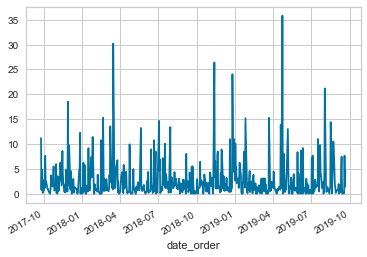

In [9]:
delivery_time = df_no_outliers.groupby(['date_order'])['delivery_time'].mean()
delivery_time.plot()
plt.show()

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


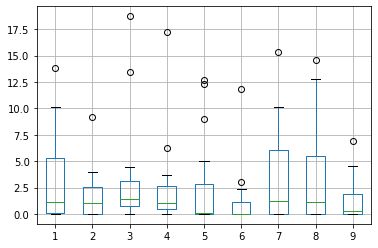

In [70]:
one_year = delivery_time['2019']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,10)
months.boxplot()
plt.show()

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


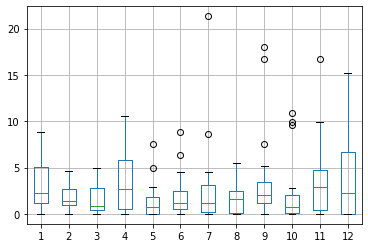

In [71]:
one_year = delivery_time['2018']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.show()

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


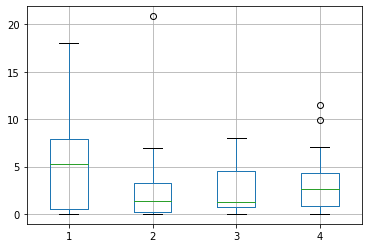

In [72]:
one_year = delivery_time['2017']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,5)
months.boxplot()
plt.show()

In [10]:
distortions = []
df_kmeans = df_no_outliers.groupby(['product_id'])[['delivery_time', 'sales_net', 'quantity']].mean()
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans)
    distortions.append(kmeanModel.inertia_)

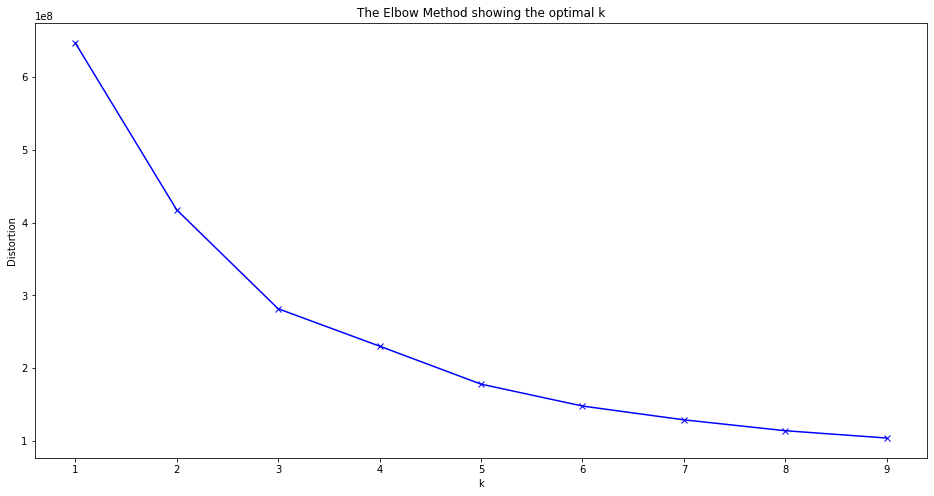

In [11]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Text(0.5, 1.0, 'Delivery time vs Net Sales')

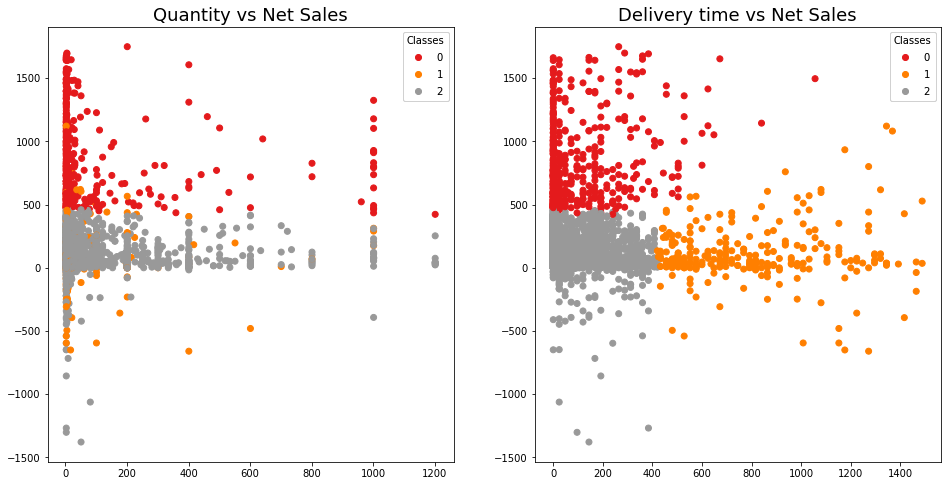

In [12]:
df_kmeans = df_no_outliers.groupby(['product_id'])[['delivery_time', 'sales_net', 'quantity']].mean()
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(df_kmeans[['delivery_time', 'sales_net', 'quantity']])

df_kmeans['k_means']=kmeanModel.predict(df_kmeans)
df_kmeans['profitable']= np.where(df_kmeans['sales_net']>0, 1, 0)
fig, axes = plt.subplots(1, 2, figsize=(16,8))
scat_1 = axes[0].scatter(df_kmeans['quantity'], df_kmeans['sales_net'], c=df_kmeans['k_means'], cmap=plt.cm.Set1)
scat_2 = axes[1].scatter(df_kmeans['delivery_time'], df_kmeans['sales_net'], c=df_kmeans['k_means'], cmap=plt.cm.Set1)

legend_1 = axes[0].legend(*scat_1 .legend_elements(), title="Classes")
legend_2 = axes[1].legend(*scat_2.legend_elements(), title="Classes")

axes[0].add_artist(legend_1)
axes[1].add_artist(legend_2)

axes[0].set_title('Quantity vs Net Sales', fontsize=18)
axes[1].set_title('Delivery time vs Net Sales', fontsize=18)